#  Book Recommendation System with Pyspark ALS

#  import libraries

In [2]:
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import SparkSession ,Row
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc, asc
from pyspark.sql.functions import col, avg
from pyspark.sql.functions import explode
from pyspark.sql.types import StructType,StructField,IntegerType
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [3]:
import pyspark
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# initialize the spark session

In [4]:
spark = pyspark.sql.SparkSession.builder \
                                .master('local[*]') \
                                .config("spark.driver.memory", "30g") \
                                .appName ("Book Recommendatin") \
                                .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext (sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/09 09:54:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#  load dataset

In [5]:
#  source : https://www.kaggle.com/datasets/zygmunt/goodbooks-10k

In [6]:
books = spark.read.csv('goodbooks/books.csv', inferSchema=True, header=True)

In [7]:
books.printSchema()

root
 |-- id: integer (nullable = true)
 |-- book_id: integer (nullable = true)
 |-- best_book_id: integer (nullable = true)
 |-- work_id: integer (nullable = true)
 |-- books_count: integer (nullable = true)
 |-- isbn: string (nullable = true)
 |-- isbn13: double (nullable = true)
 |-- authors: string (nullable = true)
 |-- original_publication_year: integer (nullable = true)
 |-- original_title: string (nullable = true)
 |-- title: string (nullable = true)
 |-- language_code: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- ratings_count: integer (nullable = true)
 |-- work_ratings_count: integer (nullable = true)
 |-- work_text_reviews_count: integer (nullable = true)
 |-- ratings_1: integer (nullable = true)
 |-- ratings_2: integer (nullable = true)
 |-- ratings_3: integer (nullable = true)
 |-- ratings_4: integer (nullable = true)
 |-- ratings_5: integer (nullable = true)
 |-- image_url: string (nullable = true)
 |-- small_image_url: string (nullable = t

In [8]:
df_books = books.toPandas()

In [9]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int32  
 1   book_id                    10000 non-null  int32  
 2   best_book_id               10000 non-null  int32  
 3   work_id                    10000 non-null  int32  
 4   books_count                10000 non-null  int32  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int3

In [10]:
df_books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780000e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780000e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780000e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780000e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780000e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


#  exploratory data analysis(EDA)

In [11]:
# books dataset

In [12]:
df_books.duplicated().sum()

0

In [13]:
df_books.isnull().sum()

id                              0
book_id                         0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64

In [14]:
df_books['original_publication_year'].max()

2017.0

In [15]:
df_books[df_books['original_publication_year'] == df_books['original_publication_year'].max()]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
5883,5884,30831912,30831912,51396954,38,None,NaN,Neil Gaiman,2017.0,Norse Mythology,...,22266,39250,5731,179,974,6943,17019,14135,https://images.gr-assets.com/books/1473864212m...,https://images.gr-assets.com/books/1473864212s...
7239,7240,27824826,27824826,47804789,45,None,NaN,Jane Harper,2017.0,The Dry,...,19843,27901,3682,257,705,4791,13128,9020,https://images.gr-assets.com/books/1456113132m...,https://images.gr-assets.com/books/1456113132s...
7372,7373,23766634,23766634,25126752,18,1408857901,9.780000e+12,Sarah J. Maas,2017.0,A Court of Wings and Ruin,...,55037,68830,12210,463,1289,5123,15585,46370,https://images.gr-assets.com/books/1485528243m...,https://images.gr-assets.com/books/1485528243s...
7447,7448,30226723,30226723,42721001,11,62310712,9.780000e+12,Victoria Aveyard,2017.0,King's Cage,...,30692,36807,5193,683,1887,6895,13675,13667,https://images.gr-assets.com/books/1467121158m...,https://images.gr-assets.com/books/1467121158s...
7466,7467,28016509,28016509,48027180,63,425285049,9.780000e+12,J.P. Delaney,2017.0,The Girl Before,...,23500,34415,4477,829,2691,9883,13716,7296,https://images.gr-assets.com/books/1485972587m...,https://images.gr-assets.com/books/1485972587s...
7559,7560,27883214,27883214,45697227,51,1250095255,9.780000e+12,Stephanie Garber,2017.0,Caraval,...,30975,35821,8360,831,2531,7001,12105,13353,https://images.gr-assets.com/books/1465563623m...,https://images.gr-assets.com/books/1465563623s...
8281,8282,29430788,29430788,49695344,14,1476799202,9.780000e+12,Alice Hoffman,2017.0,None,...,12442,15377,2481,159,533,2807,7173,4705,https://images.gr-assets.com/books/1478771334m...,https://images.gr-assets.com/books/1478771334s...
8684,8685,28965131,28965131,49193186,30,125011117X,9.780000e+12,Sarah Pinborough,2017.0,Behind Her Eyes,...,17944,21613,5003,658,1876,5082,8228,5769,https://images.gr-assets.com/books/1485279813m...,https://images.gr-assets.com/books/1485279813s...
9391,9392,29906980,29906980,50281866,2,812995341,9.780000e+12,George Saunders,2017.0,Lincoln in the Bardo,...,20373,24013,5354,996,1809,4186,7887,9135,https://images.gr-assets.com/books/1492130850m...,https://images.gr-assets.com/books/1492130850s...
9568,9569,32075671,32075671,49638190,36,62498533,9.780000e+12,Angie Thomas,2017.0,The Hate U Give,...,32610,38333,9038,208,321,1814,9207,26783,https://images.gr-assets.com/books/1476284759m...,https://images.gr-assets.com/books/1476284759s...


In [16]:
df_books['original_publication_year'].min()

-1750.0

In [17]:
df_books[df_books['original_publication_year'] == df_books['original_publication_year'].min()]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
2075,2076,19351,19351,3802528,266,141026286,9.780000e+12,"Anonymous, N.K. Sandars",-1750.0,Shūtur eli sharrī,...,44345,55856,2247,1551,5850,17627,17485,13343,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...


In [18]:
df_books['original_publication_year'].value_counts()

2012.0    568
2011.0    556
2013.0    518
2010.0    473
2014.0    437
         ... 
180.0       1
800.0       1
1898.0      1
1818.0      1
1825.0      1
Name: original_publication_year, Length: 293, dtype: int64

In [19]:
df_books['title'].nunique()

9964

In [20]:
df_books['book_id'].nunique()

10000

In [21]:
# number of book (names are same but book_id's are different)
10000-9964

36

In [22]:
#  ratings dataset

In [23]:
ratings = spark.read.csv('goodbooks/ratings.csv',inferSchema=True, header=True)

In [24]:
ratings.printSchema()

root
 |-- book_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- rating: integer (nullable = true)



In [25]:
df_ratings = ratings.toPandas()

In [26]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int32
 1   user_id  981756 non-null  int32
 2   rating   981756 non-null  int32
dtypes: int32(3)
memory usage: 11.2 MB


In [27]:
df_ratings.describe()

,book_id,user_id,rating
count,981756.000000,981756.000000,981756.000000
mean,4943.275636,25616.759933,3.856534
std,2873.207415,15228.338826,0.983941
min,1.000000,1.000000,1.000000
25%,2457.000000,12372.000000,3.000000
50%,4921.000000,25077.000000,4.000000
75%,7414.000000,38572.000000,5.000000
max,10000.000000,53424.000000,5.000000


In [28]:
df_ratings.duplicated().sum()

1644

In [29]:
df_ratings = df_ratings.drop_duplicates()

In [30]:
df_ratings.isnull().sum()

book_id    0
user_id    0
rating     0
dtype: int64

In [31]:
df_ratings.shape

(980112, 3)

In [32]:
# Group by and create basic additional columns

user_groupby = df_ratings.groupby("user_id")
book_groupby = df_ratings.groupby("book_id")
average_user_rating = user_groupby["rating"].mean()
number_of_ratings_by_user = user_groupby["rating"].count()
average_book_rating = book_groupby["rating"].mean()
number_of_book_ratings = book_groupby["rating"].count()

average_user_rating.name = "avg_rating"
number_of_ratings_by_user.name = "N_ratings"
average_book_rating.name = "avg_rating"
number_of_book_ratings.name = "N_ratings"

In [33]:
print(average_user_rating)

user_id
1        3.666667
2        4.333333
3        1.000000
4        4.000000
5        4.200000
           ...   
53420    3.333333
53421    5.000000
53422    4.166667
53423    5.000000
53424    4.250000
Name: avg_rating, Length: 53424, dtype: float64


In [34]:
print(number_of_ratings_by_user)

user_id
1         3
2         3
3         2
4         3
5         5
         ..
53420     6
53421     8
53422    18
53423     2
53424    16
Name: N_ratings, Length: 53424, dtype: int64


In [35]:
number_of_ratings_by_user.value_counts()

2      8302
3      5438
4      3976
5      3219
6      2464
       ... 
150       2
200       2
197       2
171       2
158       1
Name: N_ratings, Length: 199, dtype: int64

In [36]:
# Avg num ratings per book
print("Avg num ratings per book: ")
ratings.groupBy("book_id").count().select(avg("count")).show()

# Avg num ratings per users
print("Avg num ratings per user: ")
ratings.groupBy("user_id").count().select(avg("count")).show()

Avg num ratings per book: 


+----------+
|avg(count)|
+----------+
|   98.1756|
+----------+

Avg num ratings per user: 


+------------------+
|        avg(count)|
+------------------+
|18.376684636118597|
+------------------+



In [37]:
# calculate sparsity

numerator = ratings.select("rating").count()
num_users = ratings.select("user_id").distinct().count()
num_books = ratings.select("book_id").distinct().count()
denominator = num_users * num_books
sparsity = (1.0 - (numerator * 1.0)/denominator) * 100

print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

The ratings dataframe is  99.82% empty.


In [38]:
print("Min number of ratings by user: ", number_of_ratings_by_user.min())
print("Max number of ratings by user: ", number_of_ratings_by_user.max())

Min number of ratings by user:  1
Max number of ratings by user:  200


In [39]:
print("Min avg rating for books  : ", df_books.average_rating.min())
print("Max avg rating for books  : ", df_books.average_rating.max())

Min avg rating for books  :  2.47
Max avg rating for books  :  4.82


In [40]:
print("Min rating for books  : ", df_books.ratings_count.min())
print("Max rating for books  : ", df_books.ratings_count.max())

Min rating for books  :  2716
Max rating for books  :  4780653


In [41]:
df_books.average_rating.min()

2.47

In [42]:
df_books.average_rating.max()

4.82

In [43]:
df_books[df_books.average_rating == df_books.average_rating.min()]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
1792,1793,105578,105578,101770,25,345498321,9.780000e+12,Chetan Bhagat,2005.0,One Night @ The Call Center,...,40718,44833,1244,10559,14125,11872,5177,3100,https://images.gr-assets.com/books/1320500924m...,https://images.gr-assets.com/books/1320500924s...


In [44]:
df_books[df_books.average_rating == df_books.average_rating.max()]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
3627,3628,24812,24812,25599,14,740748475,9.780000e+12,Bill Watterson,2005.0,The Complete Calvin and Hobbes,...,28900,29968,861,120,154,693,3117,25884,https://images.gr-assets.com/books/1473064526m...,https://images.gr-assets.com/books/1473064526s...


In [45]:
df_books[df_books.ratings_count == df_books.ratings_count.max()]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780000e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...


In [46]:
df_books.ratings_count.min()

2716

In [47]:
df_books[df_books.ratings_count == df_books.ratings_count.min()]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
7638,7639,192510,192510,186149,91,964913980X,NaN,"José Mauro de Vasconcelos, قاسم صنعوی",1968.0,Meu Pé de Laranja Lima,...,2716,15091,931,164,392,1644,4516,8375,https://images.gr-assets.com/books/1502523710m...,https://images.gr-assets.com/books/1502523710s...


In [48]:
# Get top 100 best rated books in our dataset

top_books_df = df_books.loc[df_books["average_rating"] > 4] \
                        .sort_values(by="ratings_count", ascending=False) \
                        .reset_index() \
                        .head(100)

In [49]:
top_books_df = top_books_df.loc[:, ['book_id','title','authors','average_rating','ratings_count','image_url']]
top_books_df.head(10)

,book_id,title,authors,average_rating,ratings_count,image_url
0,2767052,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,4.34,4780653,https://images.gr-assets.com/books/1447303603m...
1,3,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",4.44,4602479,https://images.gr-assets.com/books/1474154022m...
2,2657,To Kill a Mockingbird,Harper Lee,4.25,3198671,https://images.gr-assets.com/books/1361975680m...
3,11870085,The Fault in Our Stars,John Green,4.26,2346404,https://images.gr-assets.com/books/1360206420m...
4,5907,The Hobbit,J.R.R. Tolkien,4.25,2071616,https://images.gr-assets.com/books/1372847500m...
5,1885,Pride and Prejudice,Jane Austen,4.24,2035490,https://images.gr-assets.com/books/1320399351m...
6,48855,The Diary of a Young Girl,"Anne Frank, Eleanor Roosevelt, B.M. Mooyaart-D...",4.10,1972666,https://images.gr-assets.com/books/1358276407m...
7,5470,1984,"George Orwell, Erich Fromm, Celâl Üster",4.14,1956832,https://images.gr-assets.com/books/1348990566m...
8,13335037,"Divergent (Divergent, #1)",Veronica Roth,4.24,1903563,https://images.gr-assets.com/books/1328559506m...
9,5,Harry Potter and the Prisoner of Azkaban (Harr...,"J.K. Rowling, Mary GrandPré, Rufus Beck",4.53,1832823,https://images.gr-assets.com/books/1499277281m...


In [50]:
# number of unique books

df_ratings['book_id'].nunique()

10000

In [51]:
# number of unique users

df_ratings['user_id'].nunique()

53424

In [52]:
# distribution of ratings

df_ratings['rating'].value_counts()

4    356854
5    292217
3    248318
2     63177
1     19546
Name: rating, dtype: int64

In [53]:
df_ratings['rating'].value_counts(normalize=True)

4    0.364095
5    0.298147
3    0.253357
2    0.064459
1    0.019943
Name: rating, dtype: float64

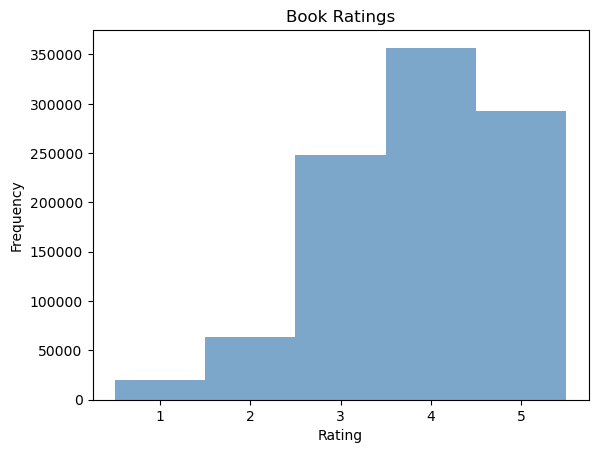

In [54]:
# the distribution of ratings

plt.hist(df_ratings['rating'], bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.7,
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
plt.title('Book Ratings')
plt.ylabel('Frequency')
plt.xlabel('Rating')
# plt.box(False)
plt.show()

In [55]:
books_ratings = df_books.merge(df_ratings, on='book_id').filter(['book_id','user_id','title','authors','image_url'])

In [56]:
books_ratings

,book_id,user_id,title,authors,image_url
0,3,314,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",https://images.gr-assets.com/books/1474154022m...
1,3,588,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",https://images.gr-assets.com/books/1474154022m...
2,3,2077,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",https://images.gr-assets.com/books/1474154022m...
3,3,2487,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",https://images.gr-assets.com/books/1474154022m...
4,3,2900,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",https://images.gr-assets.com/books/1474154022m...
...,...,...,...,...,...
79578,8914,46715,The First World War,John Keegan,https://images.gr-assets.com/books/1403194704m...
79579,8914,47073,The First World War,John Keegan,https://images.gr-assets.com/books/1403194704m...
79580,8914,49663,The First World War,John Keegan,https://images.gr-assets.com/books/1403194704m...
79581,8914,50305,The First World War,John Keegan,https://images.gr-assets.com/books/1403194704m...


In [91]:
# split dataset in train, validation and test

train_df, val_df, test_df = ratings.randomSplit([0.6, 0.2, 0.2], seed=12)


In [191]:
# create ALS model

als = ALS(userCol='user_id',
          itemCol='book_id',
          ratingCol='rating',
          seed=12,
          nonnegative=True,
          coldStartStrategy='drop'
         )

In [192]:
# traning the model

als_model = als.fit(train_df)

In [193]:
# generate predictions on the train dataset

als_pred = als_model.transform(train_df)

In [194]:
#  evaluate the predictions

evaluator = RegressionEvaluator(metricName="rmse",
                                labelCol="rating",
                                predictionCol="prediction")

train_rmse = evaluator.evaluate(als_pred)
print('The RMSE of the train data is :', train_rmse)

The RMSE of the train data is : 0.5220439558114459


In [95]:
als_pred.show(5)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|      1|  32592|     4| 4.3085356|
|      2|  32592|     4| 4.3498545|
|      3|  19984|     2| 3.5146048|
|      3|  32592|     5| 2.9521945|
|      4|  32592|     5| 4.4631243|
+-------+-------+------+----------+
only showing top 5 rows



In [126]:
# Hyperparameters

ranks =[10, 15, 20, 25]
# ranks =[5, 6, 7, 8, 9, 15]
maxIters= [5, 10, 15]
# maxIters= [15, 20]
regParams =  [0.1, 0.01, 0.02, 0.2]
# regParams =  [0.09,0.05, 0.01, 0.21, 0,27, 0.33]

In [127]:
# Loops through all models and all folds

min_error = float('inf')
best_rank = -1
best_regularization = 0
best_model = None

for rank in ranks:
    for reg in regParams:
        for maxIter in maxIters:

            # create ALS model 
            als = ALS(userCol="user_id",
                            itemCol="book_id",
                            ratingCol="rating",
                            nonnegative = True,
                            coldStartStrategy="drop" ,
                            seed=12,
                            maxIter= maxIter,
                            regParam = reg,
                            rank = rank
                           )

            # train ALS model
            model = als.fit(train_df)

            # evaluate the model by computing the RMSE on the validation data
            predictions = model.transform(train_df)
            evaluator = RegressionEvaluator(metricName="rmse",
                                                labelCol="rating",
                                                predictionCol="prediction")
            
            rmse = evaluator.evaluate(predictions)
            print('{} latent factors , regularization = {}: and iteration={} '
                    'train RMSE is {} '.format(rank, reg, maxIter, rmse))

            if rmse < min_error:
                min_error = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
                
print('\nThe best model has {} latent factors,  '
          'regularization = {} and {}  iteration'\
      .format(best_rank, best_regularization, maxIter))


10 latent factors , regularization = 0.1: and iteration=5 train RMSE is 0.5581059940946036 


10 latent factors , regularization = 0.1: and iteration=10 train RMSE is 0.5220439558114459 


10 latent factors , regularization = 0.1: and iteration=15 train RMSE is 0.5091233132419182 


10 latent factors , regularization = 0.01: and iteration=5 train RMSE is 0.45179701394038285 


10 latent factors , regularization = 0.01: and iteration=10 train RMSE is 0.410077913363685 


10 latent factors , regularization = 0.01: and iteration=15 train RMSE is 0.39512843415972304 


10 latent factors , regularization = 0.02: and iteration=5 train RMSE is 0.45163149417044235 


10 latent factors , regularization = 0.02: and iteration=10 train RMSE is 0.41305223294180493 


10 latent factors , regularization = 0.02: and iteration=15 train RMSE is 0.39972243147526076 


10 latent factors , regularization = 0.2: and iteration=5 train RMSE is 0.7258342952641422 


10 latent factors , regularization = 0.2: and iteration=10 train RMSE is 0.6735414964319731 


10 latent factors , regularization = 0.2: and iteration=15 train RMSE is 0.6597929427461583 


15 latent factors , regularization = 0.1: and iteration=5 train RMSE is 0.5007434189387489 


15 latent factors , regularization = 0.1: and iteration=10 train RMSE is 0.46929642034921576 


15 latent factors , regularization = 0.1: and iteration=15 train RMSE is 0.4580676456554413 


15 latent factors , regularization = 0.01: and iteration=5 train RMSE is 0.35557406253541374 


15 latent factors , regularization = 0.01: and iteration=10 train RMSE is 0.31134150126326887 


15 latent factors , regularization = 0.01: and iteration=15 train RMSE is 0.2949263530470533 


15 latent factors , regularization = 0.02: and iteration=5 train RMSE is 0.3601573297651629 


15 latent factors , regularization = 0.02: and iteration=10 train RMSE is 0.3184240902814562 


15 latent factors , regularization = 0.02: and iteration=15 train RMSE is 0.30335455436308056 


15 latent factors , regularization = 0.2: and iteration=5 train RMSE is 0.7067139660069958 


15 latent factors , regularization = 0.2: and iteration=10 train RMSE is 0.6568531938709414 


15 latent factors , regularization = 0.2: and iteration=15 train RMSE is 0.6433715223052477 


20 latent factors , regularization = 0.1: and iteration=5 train RMSE is 0.4696097956253754 


20 latent factors , regularization = 0.1: and iteration=10 train RMSE is 0.4397449234478917 


20 latent factors , regularization = 0.1: and iteration=15 train RMSE is 0.42925163826388707 


20 latent factors , regularization = 0.01: and iteration=5 train RMSE is 0.2900194644734414 


20 latent factors , regularization = 0.01: and iteration=10 train RMSE is 0.24639724474937863 


20 latent factors , regularization = 0.01: and iteration=15 train RMSE is 0.2294074430961651 


20 latent factors , regularization = 0.02: and iteration=5 train RMSE is 0.29848094318958324 


20 latent factors , regularization = 0.02: and iteration=10 train RMSE is 0.25767650897090877 


20 latent factors , regularization = 0.02: and iteration=15 train RMSE is 0.24184142131574182 


20 latent factors , regularization = 0.2: and iteration=5 train RMSE is 0.6975595201314447 


20 latent factors , regularization = 0.2: and iteration=10 train RMSE is 0.6477174547752834 


20 latent factors , regularization = 0.2: and iteration=15 train RMSE is 0.6343194966625868 


25 latent factors , regularization = 0.1: and iteration=5 train RMSE is 0.4452812504488312 


25 latent factors , regularization = 0.1: and iteration=10 train RMSE is 0.4189812297583597 


25 latent factors , regularization = 0.1: and iteration=15 train RMSE is 0.4099913851662089 


25 latent factors , regularization = 0.01: and iteration=5 train RMSE is 0.24586169501286084 


25 latent factors , regularization = 0.01: and iteration=10 train RMSE is 0.20404753530577563 


25 latent factors , regularization = 0.01: and iteration=15 train RMSE is 0.18687192580352055 


25 latent factors , regularization = 0.02: and iteration=5 train RMSE is 0.25741324354586814 


25 latent factors , regularization = 0.02: and iteration=10 train RMSE is 0.21761221203694625 


25 latent factors , regularization = 0.02: and iteration=15 train RMSE is 0.20230859458853861 


25 latent factors , regularization = 0.2: and iteration=5 train RMSE is 0.6887217160377889 


25 latent factors , regularization = 0.2: and iteration=10 train RMSE is 0.6413218418972256 


25 latent factors , regularization = 0.2: and iteration=15 train RMSE is 0.6284787942991211 

The best model has 25 latent factors,  regularization = 0.01 and 15  iteration


In [ ]:
# for best model 
# rank : 9, 
# regParam: 0.01, 
# MaxIteration: 15  and RMSE is 0.42055550029582256 

# en dusuk cikanlar:
# maxIter : [5, 10, 15]
# regParam :[0.01, 0.02]
# rank: [10, 15, 20, 25]
    
# 25 latent factors , regularization = 0.01: and iteration=15 train RMSE is 0.18687192580352055
# 25 latent factors , regularization = 0.2: and iteration=15 train RMSE is 0.6284787942991211 

In [133]:
# Set the ALS hyperparameters 

als = ALS(
        userCol="user_id",
        itemCol="book_id",
        ratingCol="rating",
        nonnegative = True,
        coldStartStrategy="drop",
        seed=12,
        maxIter= 15,
        regParam = 0.2,
        rank = 25
          )

In [134]:
# Fit the mdoel to the training_data
model = als.fit(train_df)

In [135]:
# Generate predictions on the train_dataset

train_predictions = model.transform(train_df)
evaluator = RegressionEvaluator(metricName="rmse",
                                  labelCol="rating",
                             predictionCol="prediction")

# Evaluate the "train_predictions" dataframe

train_rmse = evaluator.evaluate(train_predictions)
print('The RMSE of train data is:', train_rmse)

The RMSE of train data is: 0.6284787942991211


In [136]:
train_predictions.show(10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|      1|  32592|     4| 4.1535325|
|      2|  32592|     4|  4.050681|
|      3|  19984|     2| 3.6524334|
|      3|  32592|     5| 2.9154806|
|      4|  32592|     5| 4.2619777|
|      6|  35982|     2|  3.541034|
|      7|  19984|     5|  4.891856|
|      9|  32592|     3| 3.3598561|
|     17|  19984|     5| 5.0283895|
|     18|  32592|     4|  3.841711|
+-------+-------+------+----------+
only showing top 10 rows



In [137]:
# Generate predictions on the test_dataset

test_predictions = model.transform(test_df)
evaluator = RegressionEvaluator(metricName="rmse",
                                        labelCol="rating",
                                        predictionCol="prediction")

# Evaluate the "test_predictions" dataframe

test_rmse = evaluator.evaluate(test_predictions)
print('The RMSE of the test data is :', test_rmse)

The RMSE of the test data is : 0.8960263412243926


In [138]:
test_predictions.show(10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|      7|  32592|     4|  3.817233|
|      8|  32592|     4| 3.6512852|
|     11|  32592|     4| 3.8358636|
|     21|  32592|     4| 3.9931645|
|     24|  32592|     4| 4.1109004|
|     26|  32592|     4| 3.2045233|
|     26|  35982|     2|  2.543819|
|     27|  32592|     4| 3.9805567|
|     31|  32592|     5|  4.152665|
|     51|  19984|     5|  4.470134|
+-------+-------+------+----------+
only showing top 10 rows



In [ ]:

# maxIter : [5, 10, 15]
# regParam :[0.01, 0.02]
# rank: [10, 15, 20, 25]

In [144]:
# create ALS model
als = ALS(userCol='user_id',
          itemCol='book_id',
          ratingCol='rating',
          nonnegative=True,
          coldStartStrategy='drop',
          seed=12)


# Create the parameter grid
als_paramgrid = (ParamGridBuilder()
                 .addGrid(als.rank, [10, 20, 25])
                 .addGrid(als.maxIter, [5, 10, 15])
                 .addGrid(als.regParam, [ 0.1, 0.01])
                 .build())


# evaluate predictions and get RMSE 
rmse_eval = RegressionEvaluator(labelCol='rating',
                                predictionCol='prediction',
                                metricName='rmse')

# Create the CrossValidator
als_cv = CrossValidator(estimator=als,
                        estimatorParamMaps=als_paramgrid,
                        evaluator=rmse_eval,
                        numFolds=3,
                        seed=12)

In [145]:
# Fit cross validation models
als_cv = als_cv.fit(val_df)

In [146]:
# Cross Validation Results and hyperparameters:

params = [{p.name: v for p, v in m.items()} for m in als_cv.getEstimatorParamMaps()]

pd.DataFrame.from_dict([
    {als_cv.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, als_cv.avgMetrics)
])

,rmse,rank,maxIter,regParam
0,1.189617,10,5,0.10
1,1.676766,10,5,0.01
2,1.115022,10,10,0.10
3,1.413345,10,10,0.01
4,1.109025,10,15,0.10
5,1.318451,10,15,0.01
6,1.122974,20,5,0.10
7,1.292905,20,5,0.01
8,1.077716,20,10,0.10
9,1.234719,20,10,0.01


In [ ]:
# rmse:1.063275	rank:25	maxIter:15	regParam:0.33

In [147]:
# extract best combination of values from cross validation

als_best = als_cv.bestModel

In [151]:
# Evaluate the "test_predictions" dataframe

als_pred_best = als_best.transform(test_df) 

test_rmse = rmse_eval.evaluate(als_pred_best)
test_rmse

1.0177372675044565

In [ ]:
# because of the best rmse was the first basic als 'model'

In [119]:
# Print evaluation metrics and model parameters

print ("** Best Model **")
print (" RMSE     : ",  rmse_eval.evaluate(als_pred_best))
print (" Rank     : ", als_best.rank )
print (" MaxIter  : ", als_best._java_obj.parent().getMaxIter())
print (" RegParam : ", als_best._java_obj.parent().getRegParam())

** Best Model **


 RMSE     :  1.0118091182634816
 Rank     :  30
 MaxIter  :  10
 RegParam :  0.1


In [ ]:
# Generate top 10 book recommendations for each user
userRecs = als_best.recommendForAllUsers(10)

# Generate top 10 user recommendations for each book
bookRecs = als_best.recommendForAllItems(10)

In [152]:
#  with 'model'
# Generate top 10 book recommendations for each user
userRecs = model.recommendForAllUsers(10)

# Generate top 10 user recommendations for each book
bookRecs = model.recommendForAllItems(10)

In [ ]:
userRecs.printSchema()

In [153]:
# visualize recommendations
userRecs.show(10, truncate=False)

+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                                                                                                                              |
+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|26     |[{8818, 3.8447094}, {3248, 3.7278328}, {5207, 3.7266104}, {1788, 3.7203693}, {3628, 3.707313}, {4868, 3.6712635}, {8187, 3.655109}, {1380, 3.6309755}, {2209, 3.6303535}, {1877, 3.6170177}] |
|27     |[{5207, 4.6912518}, {3628, 4.671396}, {862, 4.646945}, {4868, 4.621077}, {6920, 4.6074667}, {192, 4.6073065}, {6590, 4.6062126}, {4483, 4.6042986}, {3248, 4.595508}, {9842, 4.5944943}]     |


In [154]:
bookRecs.show(10,truncate=False)

+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|book_id|recommendations                                                                                                                                                                                    |
+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|26     |[{11193, 4.4230995}, {9448, 4.418215}, {23487, 4.356769}, {30440, 4.3460603}, {52566, 4.311176}, {1653, 4.298447}, {8643, 4.2859035}, {40181, 4.2700334}, {32996, 4.2677155}, {33252, 4.260039}]   |
|27     |[{53397, 5.350847}, {1560, 5.3042727}, {52028, 5.27544}, {4134, 5.234035}, {32627, 5.230103}, {26446, 5.2300353}, {3573, 5.2127194}, {44660, 5.201069}, {30440, 5.19254

In [183]:
bookRecs.printSchema()

root
 |-- book_id: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- user_id: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [ ]:
recommendations_table= userRecs.select('user_id','recommendations.book_id')
recommendations_table.show(10, False)

In [155]:
recommendations_table = userRecs.withColumn('splited', explode('recommendations')) \
                                .select('user_id', col("splited.book_id"), col("splited.rating"))

recommendations_table.show(10)

+-------+-------+---------+
|user_id|book_id|   rating|
+-------+-------+---------+
|     26|   8818|3.8447094|
|     26|   3248|3.7278328|
|     26|   5207|3.7266104|
|     26|   1788|3.7203693|
|     26|   3628| 3.707313|
|     26|   4868|3.6712635|
|     26|   8187| 3.655109|
|     26|   1380|3.6309755|
|     26|   2209|3.6303535|
|     26|   1877|3.6170177|
+-------+-------+---------+
only showing top 10 rows



In [197]:
recommendations_table[recommendations_table.user_id == 26].show()

+-------+-------+---------+
|user_id|book_id|   rating|
+-------+-------+---------+
|     26|   8818|3.8447094|
|     26|   3248|3.7278328|
|     26|   5207|3.7266104|
|     26|   1788|3.7203693|
|     26|   3628| 3.707313|
|     26|   4868|3.6712635|
|     26|   8187| 3.655109|
|     26|   1380|3.6309755|
|     26|   2209|3.6303535|
|     26|   1877|3.6170177|
+-------+-------+---------+



23/07/09 15:18:27 WARN JavaUtils: Attempt to delete using native Unix OS command failed for path = /private/var/folders/d2/n1xb2cz570j1wrqj87c40trm0000gn/T/blockmgr-2739322a-1126-4133-a67f-f47c3006e16a. Falling back to Java IO way
java.io.IOException: Failed to delete: /private/var/folders/d2/n1xb2cz570j1wrqj87c40trm0000gn/T/blockmgr-2739322a-1126-4133-a67f-f47c3006e16a
	at org.apache.spark.network.util.JavaUtils.deleteRecursivelyUsingUnixNative(JavaUtils.java:177)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:113)
	at org.apache.spark.network.util.JavaUtils.deleteRecursively(JavaUtils.java:94)
	at org.apache.spark.util.Utils$.deleteRecursively(Utils.scala:1231)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1(DiskBlockManager.scala:368)
	at org.apache.spark.storage.DiskBlockManager.$anonfun$doStop$1$adapted(DiskBlockManager.scala:364)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.Indexe

In [159]:
# for streamlit 
recommendations_table_df = recommendations_table.toPandas()

In [ ]:
recommendations_table.count()

In [ ]:
recommendations_table.printSchema()

In [ ]:
books.createOrReplaceTempView('books_table')
recommendations_table.createOrReplaceTempView('recommendation_table')

join_table = spark.sql('SELECT `b`.`title`,  `r`.`user_id` , `b`.`authors`, `b`.`book_id`, `r`.`rating`,`b`.`image_url`, `b`.`id`\
                          FROM recommendation_table as r \
                          JOIN books_table as b ON `r`.`book_id` =`b`.`id` '
                        )

join_table = join_table.sort(desc("user_id"))
join_table.show()

In [ ]:
join_table[join_table.user_id == 16].show(10)


In [172]:
list1 = recommendations_table_df[recommendations_table_df.user_id == 26]


In [173]:
list1

,user_id,book_id,rating
0,26,8818,3.844709
1,26,3248,3.727833
2,26,5207,3.726610
3,26,1788,3.720369
4,26,3628,3.707313
5,26,4868,3.671263
6,26,8187,3.655109
7,26,1380,3.630975
8,26,2209,3.630353
9,26,1877,3.617018


In [ ]:
recommendation_tbl = join_table.toPandas()

In [ ]:
#  recommendation for one user 
for_one_user = als_pred_best.filter(col("user_id")==10)\
                          .join(books, "book_id")\
                          .select("user_id", "title", "image_url", "prediction", "rating")

for_one_user.show()

In [ ]:
# to show all predicted book image
from IPython. display import Image
from IPython.display import display

for book in for_one_user.take(5):
    print(book.title)
    display(Image (url=book.image_url))

In [ ]:
# Generate top 5 book recommendations for a specified set of users

users = ratings.select(als_best.getUserCol()).distinct().limit(3)
userSubsetRecs = als_best.recommendForUserSubset(users, 5)
userSubsetRecs.show(truncate=False)

In [184]:
# Prediction for a user and match with to-read list

book_ids = [860, 1524, 2885, 2914, 5297, 7397, 8802,9506]
user_ids = [4917,4917,4917,4917,4917,4917,4917,4917]

new_user_preds = sqlContext.createDataFrame(zip (book_ids, user_ids), schema= ['book_id', 'user_id'])

In [185]:
new_user_preds.show()

+-------+-------+
|book_id|user_id|
+-------+-------+
|    860|   4917|
|   1524|   4917|
|   2885|   4917|
|   2914|   4917|
|   5297|   4917|
|   7397|   4917|
|   8802|   4917|
|   9506|   4917|
+-------+-------+



In [190]:
new_predictions = model.transform(new_user_preds)
new_predictions.sort(desc("prediction")).show()

+-------+-------+----------+
|book_id|user_id|prediction|
+-------+-------+----------+
|    860|   4917| 3.5690165|
|   9506|   4917| 3.5475159|
|   1524|   4917| 3.5270498|
|   7397|   4917| 3.4522545|
|   2914|   4917| 3.3611915|
|   5297|   4917| 3.2906456|
|   2885|   4917| 3.2073739|
|   8802|   4917| 3.1502092|
+-------+-------+----------+



In [162]:
import pickle



# recommendation table with image_url
pickle.dump(recommendations_table_df,open('recommendation_tbl.pkl','wb'))


# pickle.dump(userRecs_df,open('user_recs.pkl','wb'))

# als_best.save("model")


# top 100 books
pickle.dump(top_books_df,open('top_100_books.pkl','wb'))

# books
pickle.dump(df_books,open('df_books.pkl','wb'))